In [1]:
import numpy as np
from PIL import Image
import taichi as ti
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from utils import run_optimization

ti.init(arch=ti.gpu)

[Taichi] version 1.7.3, llvm 15.0.1, commit 5ec301be, win, python 3.11.5
[Taichi] Starting on arch=cuda


In [ ]:
def init_trajectory(sofa_w, sofa_h, control_point_num, end_rotation=-0.5 * np.pi):  # 生成初始轨迹
    # 先直线移动到拐角，然后旋转90°，然后直线离开拐角
    assert control_point_num % 3 == 0
    xs = np.concatenate([
        np.linspace(-sofa_w / 2, 0.5, control_point_num // 3, dtype=np.float32),
        np.ones(control_point_num * 2 // 3, dtype=np.float32) * 0.5
    ])
    ys = np.concatenate([
        np.ones(control_point_num * 2 // 3, dtype=np.float32) * 0.5,
        np.linspace(0.5, -sofa_w / 2, control_point_num // 3, dtype=np.float32)
    ])
    rs = np.concatenate([
        np.ones(control_point_num // 3, dtype=np.float32) * 0,
        np.linspace(0, end_rotation, control_point_num // 3, dtype=np.float32),
        np.ones(control_point_num // 3, dtype=np.float32) * end_rotation
    ])
    return xs, ys, rs

sofa_w = 3.5   # 求解域的尺寸
sofa_h = 1.0   # 求解域的尺寸

xs, ys, rotations = init_trajectory(
    sofa_w=sofa_w,
    sofa_h=sofa_h,
    control_point_num=30,  # 轨迹的控制点数量
    end_rotation=-0.5 * np.pi)  # 初始轨迹

In [3]:
# xs, ys, rotations = np.load('trajectory/1/sofa_6000.npy')

In [ ]:
@ti.func
def is_forbidden(x, y):  # 指定哪里是墙
    return (x < 0.0 and y < 0.0) or x > 1.0 or y > 1.0

best_score, xs, ys, rotations, sofa, maximal_area_record = run_optimization(
    is_forbidden,
    xs,
    ys,
    rotations,
    sofa_w=sofa_w,
    sofa_h=sofa_h,
    # initial_xs=zoom(xs, zoom=2, order=1),
    # initial_ys=zoom(ys, zoom=2, order=1),
    # initial_rotations=zoom(rotations, zoom=2, order=1),
    mutation_sigma_pos = 0.02,  # 变异率
    mutation_sigma_rotation = 0.004,  # 变异率
    iterations = 200000,
    trajectory_upsampling=101,  # 41
    resolution=2100,  # 1024
    print_every=1000,
    save_image_every=83,
    save_image_path='images/2/sofa_',
    save_image_start_id=0,
    save_trajectory_path='trajectory/2/sofa_'
)
print(f"Estimated maximal sofa area (by sampling): {best_score:.5f}")
# save mask image as PNG if pillow is available

img = (sofa * 255).astype(np.uint8)
im = Image.fromarray(img.T[::-1])
im.save('sofa_survivors.png')
print('Saved sofa_survivors.png')
plt.plot(maximal_area_record)

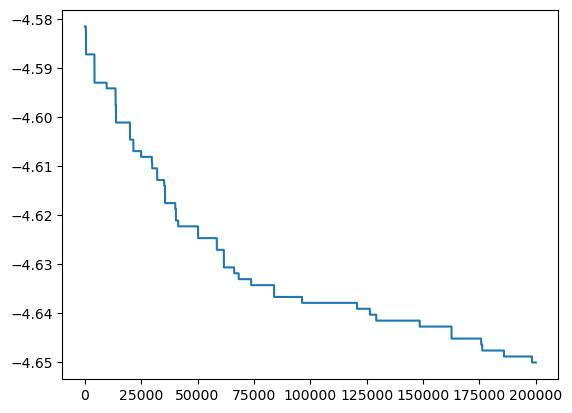

In [40]:
plt.plot(np.log(2.2195 - np.array(maximal_area_record)))

In [42]:
maximal_area_record[-1] / 2.2195

0.9956923818018931

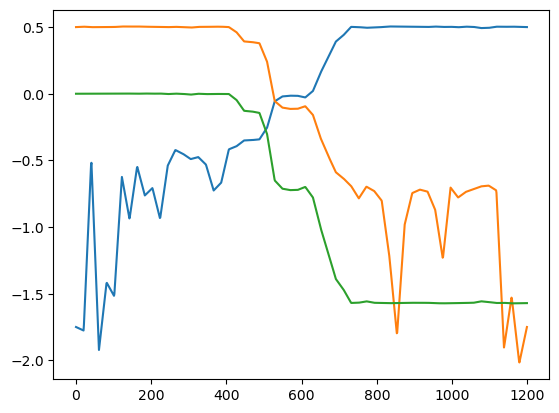

In [41]:
plt.plot(zoom(xs, zoom=20, order=1))
plt.plot(zoom(ys, zoom=20, order=1))
plt.plot(zoom(rotations, zoom=20, order=1))